Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name below:

In [1]:
NAME = "Maria Baba"
STUDENT_ID = "14201089"

---

## Overview
Welcome to the clustering task. In previous courses, you've learned the application of several clustering methods. Now it's time to put them to use in a real-world task. One of the most classic application is the analysis of business data. By the means of clustering, we can analyze daily transactional data of some business to perform tasks like customer segmentation.

In the following tasks, we will analyze a database provided by a real online retailer to help them to perform a basic customer segmentation.

Online retailing refers to the sale of goods or the provision of services targeted to the needs of individuals or households via the Internet or other electronic channels. The attached document incluedes a database collected by one retailer for all its transactions registered for non-store online retailing in the UK between 12/12/2010 and 12/9/2011. The company primarily sells unique all-occasion gifts.

You will try to use your what you had learned to help them analyze their customers. Many of the tasks you may have come across before, but today is the first time we can combine them together.

## Goal
We aim to separate the customers into several groups so that the company can target its customers efficiently. Ideally 3 or 4 groups.

## The steps are broadly divided into:

1. [Step 1: Reading and Understanding the Data](#1)
2. [Step 2: Data Cleaning](#2)
3. [Step 3: Feature Engineering](#3)
   1. [Step 3.1: Feature Creation](#3)
   2. [Step 3.2: Outlier detection](#3.2)
   3. [Step 3.3: Standarization](#3.3)
4. [Step 4: Model Building](#4)
5. [Step 5: Final Analysis](#5)

**This code is adopted from the code of MANISH KUMAR. The origin is https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering

<a id="1"></a> <br>
## Step 1 : Reading and Understanding Data

Import the packages and set the random seed to unify the result.

In [2]:
# Import required libraries for dataframe and visualization
# If you some packages are installed in your computer, you 
# can install them by using "pip"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

np.random.seed(42)

As the first step in the analysis, we need to load the data and do some inspections.

You can use this code to load the database.

In [3]:
# Reading the data on which analysis needs to be done
retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)

### Task 1

Print the basic information of the data and check whether there are problems inside.

At least you should check them by using the dataframe.info function

In [4]:
# YOUR CODE HERE
display(retail)
retail.info()

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

             InvoiceDate  UnitPrice  CustomerID         Country  
0       01-12-2010 08:26       2.55     17850.0  United Kingdom  
1       01-12-2010 08:26       3.39     17850.0  United Kingdom  
2       01-12-2010 08:26       2.75     17850.0  United Kingdom  
3       01-12-2010 08:26       3.39     17850.0  United Kingdom  
4       01-12-2010 08:26       3.39     17850.0  United Kingdom  
...                  ...        ...         ...             ...  
541904  09-12-2011 12:50       0.85     12680.0          France  
541905  09-12-2011 12:50       2.10     12680.0          France  
541906  09-12-2011 12:50       4.15     12680.0          France  
541907  09-12-2011 12:50       4.15     12680.0          France  
541908  09-12-2011 12:50       4.95     12680.0          France  

[541909 rows x 8 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


<a id="2"></a> <br>
## Step 2 : Data Cleaning

### By observing the information of the data, at least three issues are found:
1. Missing values exist in "Description" and "CunstomerID"
2. "CustomerID" should be string type rather than integer
3. “InvoiceData” need to be datetime type for further usage

### Task 2
1. delete all columns that have missing value
2. Convert the "CustomerID" into string type
3. Convert the "InvoiceData" into datetime type with the format '%d-%m-%Y %H:%M'

In [5]:
# YOUR CODE HERE
# Delete columns with missing values
retail = retail.dropna()

#Convert CustomerID values to string
retail['CustomerID']=retail['CustomerID'].values.astype('str')

#Convert InvoiceDate into datetime
retail['InvoiceDate']=pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [6]:
assert len(retail) == 406829

<a id="3"></a> <br>
## Step 3 : Feature Engineering
## 3.1 : Feature Creation

### Next, we deal with the features. We adopt a simple and classic approach, i.e. we calculate the following 3 factors:
- Recency: Number of days since last purchase
- Frequency: Number of tracsactions
- Monetary: Total amount of transactions (revenue contributed)

You can run the following code to compute the attribute "Recency".

In [7]:
# New Attribute : Recency

# Compute last transaction date to get the recency of customers
max_date = max(retail['InvoiceDate'])
retail['Recency'] = max_date - retail['InvoiceDate']

# Compute recency by grouping the same Customers together
rfm_p = retail.groupby('CustomerID')['Recency'].min()
rfm_p = rfm_p.reset_index()

# Extract number of days only
rfm_p['Recency'] = rfm_p['Recency'].dt.days
rfm_p.head()

CustomerID  Recency
0    12346.0      325
1    12347.0        1
2    12348.0       74
3    12349.0       18
4    12350.0      309

### Task 3
Compute the other two attributes: "Monetary" and "Frequency".

Quantity times the UnitPrice is the amount of one order and you can sum up all orders for the same CustomerID to get the Monetary, save this in a `df` called `rfm_m` in column 'Amount'.

You can count how many InvoiceNo for one CustomerID to get the Frequency, save this in a `df` called `rfm_f` in column 'Frequency'. 

In [8]:
#Get amount

#Get values for quantity and unit price and then multiply them to get one order value.
quantity=retail['Quantity'].values.tolist()
unit_price=retail['UnitPrice'].values.tolist()
one_order= np.multiply(quantity, unit_price)

#Create dataframe with customer ID and append list of one order values.
rfm_m = pd.DataFrame().assign(CustomerID=retail['CustomerID'])
rfm_m['Amount']=one_order

#Add sum of orders based on customer ID
rfm_m= rfm_m.groupby('CustomerID').sum().reset_index()
display(rfm_m)


#Get frequency

#Group items by customer ID and count invoice numbers
rfm_f= retail.groupby('CustomerID')['InvoiceNo'].count().reset_index().rename(columns={'InvoiceNo':'Frequency'})
display(rfm_f)



CustomerID   Amount
0       12346.0     0.00
1       12347.0  4310.00
2       12348.0  1797.24
3       12349.0  1757.55
4       12350.0   334.40
...         ...      ...
4367    18280.0   180.60
4368    18281.0    80.82
4369    18282.0   176.60
4370    18283.0  2094.88
4371    18287.0  1837.28

[4372 rows x 2 columns]

CustomerID  Frequency
0       12346.0          2
1       12347.0        182
2       12348.0         31
3       12349.0         73
4       12350.0         17
...         ...        ...
4367    18280.0         10
4368    18281.0          7
4369    18282.0         13
4370    18283.0        756
4371    18287.0         70

[4372 rows x 2 columns]

In [9]:
# Check if columns exist in rfm_m and rfm_f
assert 'CustomerID' in rfm_m.columns, "Expected column name: CustomerID"
assert 'Amount' in rfm_m.columns, "Expected column name: Amount"
assert 'CustomerID' in rfm_f.columns, "Expected column name: CustomerID"
assert 'Frequency' in rfm_f.columns, "Expected column name: Frequency"


### Task 4
Merge all three attributes to form a `dataframe` called "rfm".

In [10]:
#Merging dataframes to create rfm
rfm= rfm_m.merge(rfm_f,on='CustomerID').merge(rfm_p,on='CustomerID')
display(rfm)

CustomerID   Amount  Frequency  Recency
0       12346.0     0.00          2      325
1       12347.0  4310.00        182        1
2       12348.0  1797.24         31       74
3       12349.0  1757.55         73       18
4       12350.0   334.40         17      309
...         ...      ...        ...      ...
4367    18280.0   180.60         10      277
4368    18281.0    80.82          7      180
4369    18282.0   176.60         13        7
4370    18283.0  2094.88        756        3
4371    18287.0  1837.28         70       42

[4372 rows x 4 columns]

<a id="3.2"></a> <br>
## 3.2 : Outlier detection

### Task 5
Plot the distribution of all three attributes in "rfm".

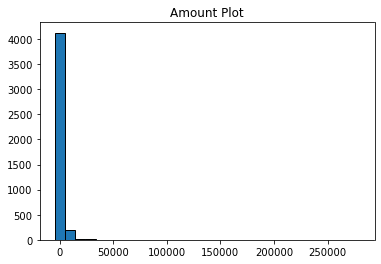

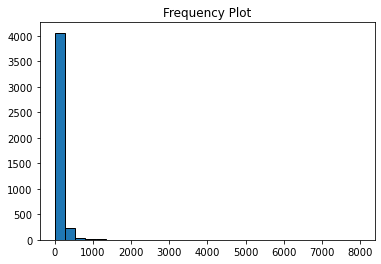

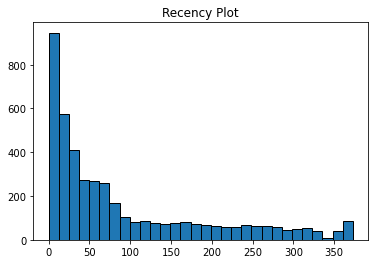

In [11]:
#Plot Amount column
plt.hist(rfm['Amount'], bins=30, edgecolor='black')
plt.title('Amount Plot')
plt.show()

#Plot Frequency column
plt.hist(rfm['Frequency'], bins=30, edgecolor='black')
plt.title('Frequency Plot')
plt.show()

#Plot Recency column
plt.hist(rfm['Recency'], bins=30, edgecolor='black')
plt.title('Recency Plot')
plt.show()

Observing them after plotting, do you think the distributions are indicating some problems?

# Answer cell
#### The distribution above is abnormal because most of the data lies in a very narrow band. The exact reason can actually be traced to outliers. 
#### In our distribution, the outliers occupy a extremely high value that makes the plot too wide and the data too narrow.

### Task 6
In this circumstance, we need to remove the extreme value before modeling. Please use the function `dataframe.quantile()` to detect the 0.99 percent point and use it as a threshold to delete all points higher than this value for all three attributes.
Save the rest of the data in `rfm`

After that, you can plot the distribution again. This time you should be able to see the shape of the distribution.

In [12]:
# YOUR CODE HERE

#Establish customer ID as a value
customer_column='CustomerID'

#For columns in the dataframe that are not customer ID, apply treshold of 0.99 percent.
for column in rfm.columns:
    if column != customer_column:
        column_threshold=rfm[column].quantile(0.99)
        rfm=rfm[rfm[column]<=column_threshold]
        
display(rfm)

CustomerID   Amount  Frequency  Recency
0       12346.0     0.00          2      325
1       12347.0  4310.00        182        1
2       12348.0  1797.24         31       74
3       12349.0  1757.55         73       18
4       12350.0   334.40         17      309
...         ...      ...        ...      ...
4366    18278.0   173.90          9       73
4367    18280.0   180.60         10      277
4368    18281.0    80.82          7      180
4369    18282.0   176.60         13        7
4371    18287.0  1837.28         70       42

[4243 rows x 4 columns]

In [13]:
assert len(rfm) == 4244

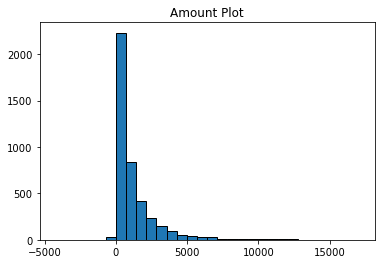

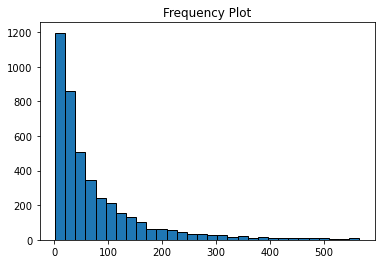

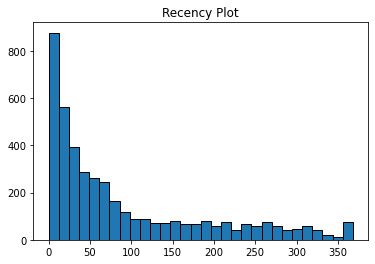

In [14]:
#Plot amount column
plt.hist(rfm['Amount'], bins=30, edgecolor='black')
plt.title('Amount Plot')
plt.show()

#Plot frequency column
plt.hist(rfm['Frequency'], bins=30, edgecolor='black')
plt.title('Frequency Plot')
plt.show()

#Plot recency column
plt.hist(rfm['Recency'], bins=30, edgecolor='black')
plt.title('Recency Plot')
plt.show()

<a id="3.3"></a> <br>
### Step 3.3 : Standarization

It is extremely important to rescale the variables so that they have a comparable scale.

### Task 7
Please use a `Standardisation Scaling` to transform all three attributes and stored the data in a new `dataframe` called "rfm_df_scaled".
Be sure to run the cell below so your `dataframe` has the correct columns on the correct place.

In [15]:
# YOUR CODE HERE

#Create standardize function
standardize = StandardScaler()  

#Apply standardization over amount, frequency and recency columns.
columns=rfm[['Amount', 'Frequency', 'Recency']]
transformed_data =standardize.fit_transform(columns)
rfm_df_scaled=pd.DataFrame(transformed_data, columns=['Amount', 'Frequency', 'Recency'])
display(rfm_df_scaled)


Amount  Frequency   Recency
0    -0.688991  -0.796451  2.404747
1     1.593710   1.149657 -0.910874
2     0.262880  -0.482911 -0.163836
3     0.241859  -0.028819 -0.736906
4    -0.511883  -0.634275  2.241013
...        ...        ...       ...
4238 -0.596888  -0.720769 -0.174069
4239 -0.593340  -0.709957  1.913544
4240 -0.646186  -0.742392  0.920905
4241 -0.595458  -0.677522 -0.849473
4242  0.284086  -0.061254 -0.491304

[4243 rows x 3 columns]

In [16]:
# Run this cell
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

Amount  Frequency   Recency
0 -0.688991  -0.796451  2.404747
1  1.593710   1.149657 -0.910874
2  0.262880  -0.482911 -0.163836
3  0.241859  -0.028819 -0.736906
4 -0.511883  -0.634275  2.241013

<a id="4"></a> <br>
## Step 4 : Building the Model
Now it is time to cluster the customers into groups. We use k-mean and hierachical clustering to achieve this task. 
We will be calculating the silhoute score for various settings and saving this in a dictionary.

### Task 8
Perform kmean clustering on the data with the number of clusters set to be 3.

And compute the Silhouette Scores.

In [17]:
# Initialize an empty dictionary
silhouette_scores = {}

In [18]:
silhouette_scores['Kmean3'] = 0

#Application of kmean with 3 clusters
kmean=KMeans(n_clusters=3)
clusters=kmean.fit_predict(rfm_df_scaled)
sk=silhouette_score(rfm_df_scaled,clusters)

silhouette_scores['Kmean3'] = sk


c:\Users\maria\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Task 9
Perform hierachical clustering on the data, the algorithm can be chosen as agglomerative clustering, number of clusters is 3, linkage is "ward".

Compute the Silhouette Scores.

In [19]:
silhouette_scores['Ward3'] = 0

#Application of agglomerative clustering with 3 clusters
hierarchial=AgglomerativeClustering(n_clusters=3, linkage='ward',affinity='euclidean')
clusters_h=hierarchial.fit_predict(rfm_df_scaled)
sh=silhouette_score(rfm_df_scaled,clusters_h)

silhouette_scores['Ward3'] = sh
#print(silhouette_scores)

c:\Users\maria\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


### Task 10
Change the number of cluster to be 4 for both kmean and hierachical clustering.

Compute the Silhouette scores for both cases.

After that, the variable "silhouette_scores" should have four values.

In [20]:
silhouette_scores['Kmean4'] = 0

# Application of kmean with 4 clusters
kmean_4=KMeans(n_clusters=4)
clusters_k4=kmean_4.fit_predict(rfm_df_scaled)
sk_4=silhouette_score(rfm_df_scaled,clusters_k4)

silhouette_scores['Kmean4'] = sk_4
#print(silhouette_scores)

c:\Users\maria\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [21]:
silhouette_scores['Ward4'] = 0

# Application of agglomerative clustering with 4 clusters
h4=AgglomerativeClustering(n_clusters=4, linkage='ward', affinity='euclidean')
clusters_h4=h4.fit_predict(rfm_df_scaled)
sh4=silhouette_score(rfm_df_scaled,clusters_h4)

silhouette_scores['Ward4'] = sh4
#print(silhouette_scores)

c:\Users\maria\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [22]:
print(silhouette_scores)

{'Kmean3': 0.5065945252812358, 'Ward3': 0.47585021508535236, 'Kmean4': 0.4877389840008691, 'Ward4': 0.42338712529962613}


### Additional Task
You can use the scatter plot (Amount vs. Frequency) to show the differences between these two methods.

By observing the plot we know that the kmean shows clearer boundaries. 

According to their mechanism, do you know why?

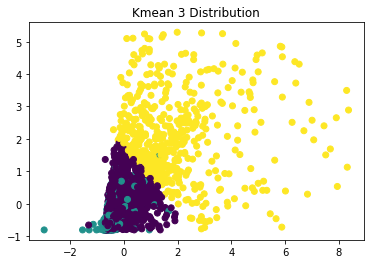

In [23]:
#Scatter plot for kmean with 3 clusters
plt.scatter(rfm_df_scaled['Amount'], rfm_df_scaled['Frequency'], c=clusters)
plt.title('Kmean 3 Distribution')
plt.show()

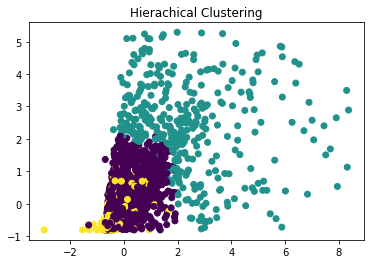

In [24]:
# Scatter plot for agglomerative clustering with 3 clusters
plt.scatter(rfm_df_scaled['Amount'], rfm_df_scaled['Frequency'], c=clusters_h)
plt.title('Hierachical Clustering')
plt.show()

YOUR ANSWER HERE: Although the plots are very similar, the kmean plot shows a slightly clearer boundary between clusters. This is mostly because the kmean algorithm divides and separates values into sets or groupings that are not overlapping, while hierarchial clustering creates nested clusters. 

Reference: “Difference between K Means and Hierarchical Clustering.” GeeksforGeeks, 8 July 2020, https://www.geeksforgeeks.org/difference-between-k-means-and-hierarchical-clustering/.

### Task 11
Record the result of kmean with 3 clusters as a new column named "ClusterLabel" in "rfm".

In [25]:
# YOUR CODE HERE
kmean=KMeans(n_clusters=3, random_state=0)
rfm['ClusterLabel'] = kmean.fit_predict(rfm_df_scaled)

# Print the first few rows of the DataFrame with the new ClusterLabel column
print(rfm.head())

  CustomerID   Amount  Frequency  Recency  ClusterLabel
0    12346.0     0.00          2      325             2
1    12347.0  4310.00        182        1             1
2    12348.0  1797.24         31       74             0
3    12349.0  1757.55         73       18             0
4    12350.0   334.40         17      309             2


c:\Users\maria\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [26]:
assert 'ClusterLabel' in rfm.columns, "Missing column"

<a id="5"></a> <br>
## Step 5 : Result Analysis

### Task 12
Plot scatter plots of both Amount vs. Recency and Amount vs. Frequency. Try to identify differences between clusters?

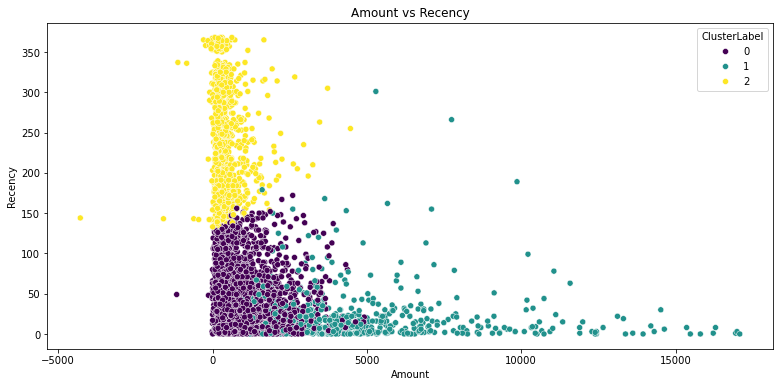

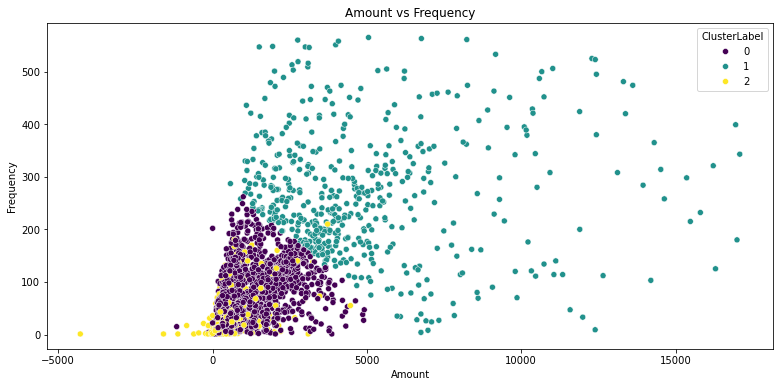

In [27]:
# YOUR CODE HERE

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

#Amount vs Recency plot
fig = plt.subplots( figsize=(13, 6))
sns.scatterplot(x='Amount', y='Recency', hue='ClusterLabel', data=rfm, palette='viridis').set(title='Amount vs Recency')

#Amount vs Frequency Plot
fig = plt.subplots( figsize=(13, 6))
sns.scatterplot(x='Amount', y='Frequency', hue='ClusterLabel', data=rfm, palette='viridis').set(title='Amount vs Frequency')

warnings.resetwarnings()

### Additional Task
You can use the "ClusterLabel" as the x-axis to draw a box plot for each attribute, in this case you can see the differences clearly.

c:\Users\maria\anaconda3\lib\site-packages\seaborn\utils.py:159: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout = method([], [], **kws)
c:\Users\maria\anaconda3\lib\site-packages\seaborn\utils.py:159: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout = method([], [], **kws)
c:\Users\maria\anaconda3\lib\site-packages\seaborn\categorical.py:691: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  artists = ax.bxp(**boxplot_kws)
c:\Users\maria\anaconda3\lib\site-packages\seaborn\utils.py:159: MatplotlibDeprecationWarning: Support for passing numbers th

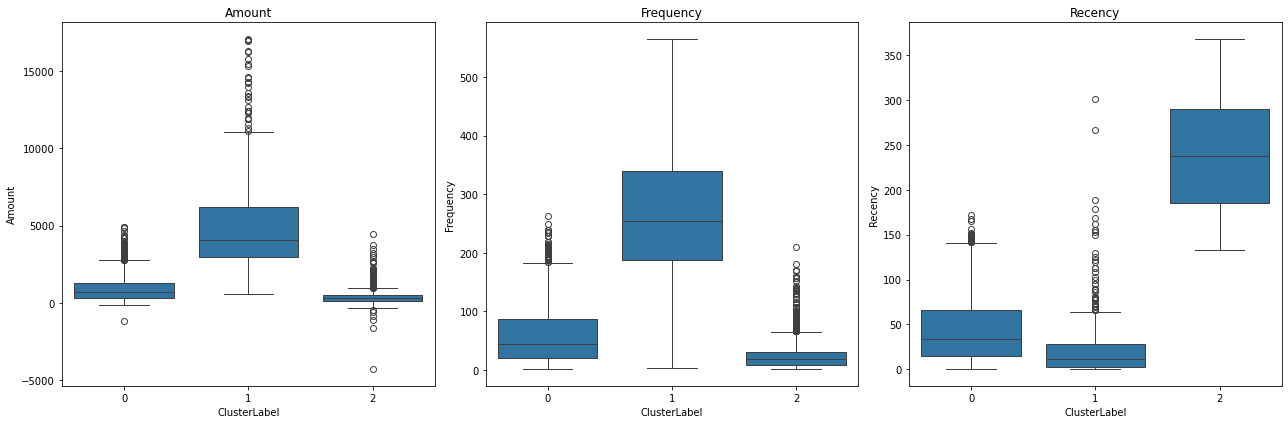

In [28]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

#Amount Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.boxplot(x='ClusterLabel', y='Amount', data=rfm, ax=axes[0]).set(title='Amount')

#Frequency Plot
sns.boxplot(x='ClusterLabel', y='Frequency', data=rfm, ax=axes[1]).set(title='Frequency')

#Recency Plot
sns.boxplot(x='ClusterLabel', y='Recency', data=rfm, ax=axes[2]).set(title='Recency')

plt.tight_layout()
plt.show()
warnings.resetwarnings()

#### According to the figures above, we can separate all customers into three type of groups:
- Good buyers: They are loyal supporters of the company, either bought many times or bought large amounts.
- Potential buyers: They have bought a certain amount of products and are quite active in recent days. They may become our loyal supporters in the future, even though the amount may not be large.
- Lost Buyers: They haven't buy any products for a long time. In the beginning they tried to buy some small amount and after that they disappeared.

### Final Task:
Determine which type of buyer matches which of the 3 clusters we obtained by eyeballing the plots.

In [29]:
# YOUR CODE HERE
Good_buyer_cluster = rfm[rfm['ClusterLabel']==1]
Potential_buyer_cluster = rfm[rfm['ClusterLabel']==2]
Lost_buyer_cluster = rfm[rfm['ClusterLabel']==0]

print('Good buyer cluster is cluster 1')
print('Potential buyer cluster is cluster 2')
print('Lost buyer cluster is cluster 0')

Good buyer cluster is cluster 1
Potential buyer cluster is cluster 2
Lost buyer cluster is cluster 0


#### Congratulations, the analysis is complete. 
#### After we present the results to the company, all departments of the company have developed meaningful strategies based on your analysis. And the analysis help them make dramatic improvement in their future sales.

End